# **COMP 2211 Exploring Artificial Intelligence**
## Convolutional Neural Network

![fruit.jpg](https://pic.pimg.tw/fsixteenart/1567950247-3939100531_l.png)

**Check your Colab open the GPU accelerator:**

1. 'Edit' -> 'Notebook settings':

![gpu1.png](https://drive.google.com/uc?export=view&id=19RK_MicAY8J4BIY5g0i7bw6sr3WEFaDz)


2. Set 'Hardware accelerator':

![gpu2.png](https://drive.google.com/uc?export=view&id=1kTK1oZ-UWdIr0hxbXVT8GQDHMGHXVbLI)

In [1]:
# check your Colab device
import tensorflow as tf  # Import tensorflow library
import pprint            # Import pprint library for better print format
device_name = tf.config.list_physical_devices()  # A list of divece name, which could contain CPU and GPU
pprint.pprint(device_name)                       # Print the device_name

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## **Reminder**: DO NOT leave the task to the last day. If you use GPU frequently within a time, Colab will limit you access to GPU for a while and your training will be much slower. 

## **Lab Tasks Procedure**
0. Data preparation
1. Data preprocessing **(Task 1)**
2. Data generator **(Task 2)**
3. Build the model **(Task 3)**
4. Compile the model
5. Train the model
6. Save the model

## **Data Preparation**


1. Download the PokemonData from [here](https://course.cse.ust.hk/comp2211/labs/lab8/PokemonData.zip)
2. Upload this data to your Google Drive, under folder `comp2211/lab8`.
3. Run the following code cell to mount Google Drive and unzip the data.

Note: If this lasts for more than one minute, you may try deleting the previously unzipped folder on Google Drive and try again.



In [2]:
from google.colab import drive
drive.mount("/content/drive")
%cd "drive/MyDrive/comp2211/lab8"
!unzip -q PokemonData.zip -d .
!ls

Mounted at /content/drive
/content/drive/MyDrive/comp2211/lab8
lab8_review.ipynb  lab8_task.ipynb  lab8_task.py  PokemonData  PokemonData.zip


## **Pokemon Recognition**
---
About the data:
- Number of images: **6375**.
- Number of classes: **150**.
- Image size: various.

Before data preprocessing, we visualize some of the images to get familiar with the data.

32
IMAGE 

[[[251 119 140]
  [251 119 140]
  [249 122 143]
  ...
  [248 133 202]
  [248 133 202]
  [247 132 201]]

 [[251 120 138]
  [250 121 139]
  [249 122 141]
  ...
  [253 138 207]
  [253 138 207]
  [252 137 206]]

 [[252 121 137]
  [250 122 137]
  [250 123 140]
  ...
  [255 139 204]
  [254 138 203]
  [254 138 203]]

 ...

 [[243 167 197]
  [253 180 210]
  [255 191 219]
  ...
  [253 111 127]
  [252 110 126]
  [252 110 126]]

 [[241 164 196]
  [251 178 208]
  [254 189 219]
  ...
  [255 110 127]
  [254 109 126]
  [254 109 126]]

 [[239 162 194]
  [250 177 207]
  [252 187 217]
  ...
  [255 109 128]
  [254 108 127]
  [254 108 127]]]




IMAGE 

[[[120 151 172]
  [120 151 172]
  [120 151 172]
  ...
  [ 35  33  38]
  [ 36  31  37]
  [ 35  30  36]]

 [[117 148 169]
  [117 148 169]
  [117 148 169]
  ...
  [ 35  33  38]
  [ 38  33  39]
  [ 38  33  39]]

 [[115 146 167]
  [115 146 167]
  [115 146 167]
  ...
  [ 37  35  40]
  [ 37  35  40]
  [ 38  33  37]]

 ...

 [[ 98  60 119]
  [ 98  60 11

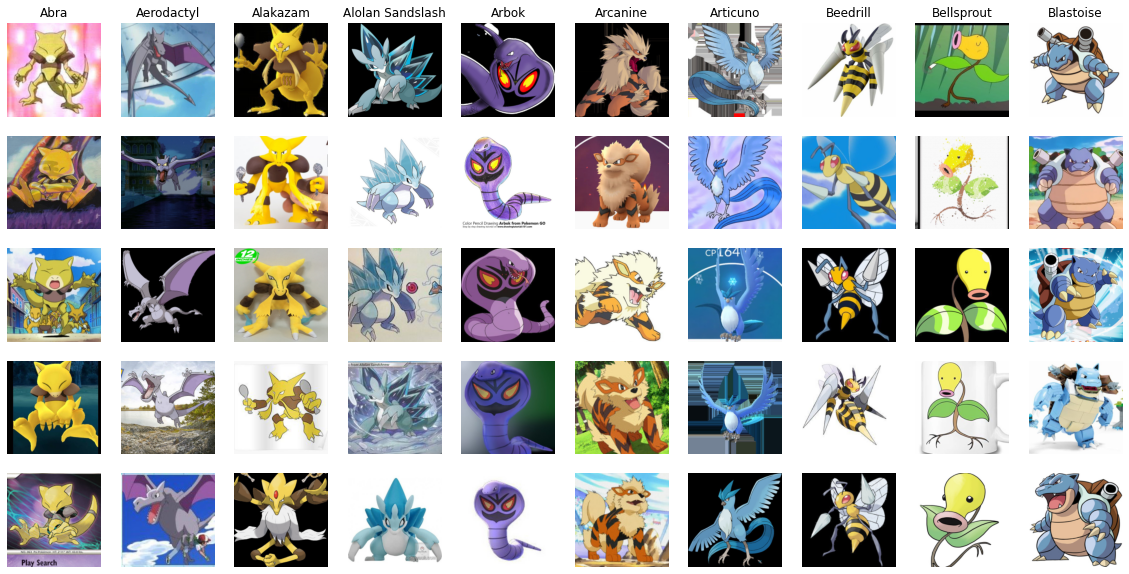

In [3]:
import os, cv2
import matplotlib.pyplot as plt

data_dir = './PokemonData'
# os.list() returns the list of subfolder's name
# sorted() rearranges the order of the list
category_list = sorted(os.listdir(data_dir))

plt.figure(figsize=(20,10))
for i in range(10): # we only show first 10 categories
  img_names = sorted(os.listdir('{}/{}'.format(data_dir, category_list[i])))
  print(len(img_names))
  for j in range(5): # we only show first 5 images of each category
    img = plt.imread('{}/{}/{}'.format(data_dir, category_list[i], img_names[j])) # read the image
    print("IMAGE \n")
    print(img)
    print('\n')
    print('\n')
    img = cv2.resize(img,(200, 200),interpolation=cv2.INTER_AREA) # resize them to the same size for convenience
    plt.subplot(5, 10, 10*j+i+1) # plot the same category at the same column
    plt.imshow(img)
    plt.axis('off')
    if j == 0: # only show category name at the first row
      plt.title(category_list[i])
plt.show()


In [4]:
# Import necessary libraries
import numpy as np

from sklearn.model_selection import train_test_split
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten

## 1. Data preprocessing

We first construct a mapping from string-type category names to integer-type class indices, for later use.

In [5]:
data_dir = './PokemonData'
# os.list() returns the list of subfolder's name
# sorted() rearranges the order of the list
category_list = sorted(os.listdir(data_dir)) 

# Create a dict mapping the category name to the class index
# The number of label should be 150 (0 to 149)
cate2Idx = {}
for i in range(len(category_list)):
  cate2Idx[category_list[i]] = i
print(cate2Idx)

{'Abra': 0, 'Aerodactyl': 1, 'Alakazam': 2, 'Alolan Sandslash': 3, 'Arbok': 4, 'Arcanine': 5, 'Articuno': 6, 'Beedrill': 7, 'Bellsprout': 8, 'Blastoise': 9, 'Bulbasaur': 10, 'Butterfree': 11, 'Caterpie': 12, 'Chansey': 13, 'Charizard': 14, 'Charmander': 15, 'Charmeleon': 16, 'Clefable': 17, 'Clefairy': 18, 'Cloyster': 19, 'Cubone': 20, 'Dewgong': 21, 'Diglett': 22, 'Ditto': 23, 'Dodrio': 24, 'Doduo': 25, 'Dragonair': 26, 'Dragonite': 27, 'Dratini': 28, 'Drowzee': 29, 'Dugtrio': 30, 'Eevee': 31, 'Ekans': 32, 'Electabuzz': 33, 'Electrode': 34, 'Exeggcute': 35, 'Exeggutor': 36, 'Farfetchd': 37, 'Fearow': 38, 'Flareon': 39, 'Gastly': 40, 'Gengar': 41, 'Geodude': 42, 'Gloom': 43, 'Golbat': 44, 'Goldeen': 45, 'Golduck': 46, 'Golem': 47, 'Graveler': 48, 'Grimer': 49, 'Growlithe': 50, 'Gyarados': 51, 'Haunter': 52, 'Hitmonchan': 53, 'Hitmonlee': 54, 'Horsea': 55, 'Hypno': 56, 'Ivysaur': 57, 'Jigglypuff': 58, 'Jolteon': 59, 'Jynx': 60, 'Kabuto': 61, 'Kabutops': 62, 'Kadabra': 63, 'Kakuna': 64, 

### **Task 1**

You need to implement the core of the function `data_preprocessing`, which returns the processed images as `x` and the labels as `y`. See more detailed descriptions below.

In [6]:
# Input: data_dir(str)  -- the root folder of the data.
#        cate2Idx(dict) -- a mapping from category name to class index.
#        img_size(int) -- an integer indicating the size of the preprocessed image (square)
# Return: x(array) -- the images data, the shape in this task should be (6375, 64, 64, 3).
#         y(array) -- the label of images, the shape in this task should be (6375,).
# Here are some useful functions that might be useful for you:
#     cv2.imread()   -- read image data.
#     cv2.cvtColor() -- convert the color space.
#     cv2.resize()   -- resize an image to a certain shape
def data_preprocessing(data_dir, cate2Idx, img_size):
  x = []
  y = []
  # Hints: OpenCV reads an image with its channel being 'BGR' order,
  # you need to change the order back to 'RGB'
  ###############################################################################
  # TODO: your code starts here
  category_list = sorted(os.listdir(data_dir))

  # y = list(cate2Idx.values())
  for i in range(len(category_list)):
    img_names = sorted(os.listdir('{}/{}'.format(data_dir, category_list[i])))
    for j in range(len(img_names)):
      img = cv2.imread('{}/{}/{}'.format(data_dir, category_list[i], img_names[j]))
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (img_size, img_size), interpolation=cv2.INTER_AREA)
      x.append(img)
      y.append(cate2Idx[category_list[i]])
  # for i in range(10): # we only show first 10 categories
  # img_names = sorted(os.listdir('{}/{}'.format(data_dir, category_list[i])))
  # for j in range(5): # we only show first 5 images of each category
  #   img = plt.imread('{}/{}/{}'.format(data_dir, category_list[i], img_names[j])) # read the image
  #   img = cv2.resize(img,(200, 200),interpolation=cv2.INTER_AREA) # resize them to the same size for convenience

  # TODO: your code ends here
  ###############################################################################
  x = np.asarray(x)
  y = np.asarray(y)
  return x, y

Run the following code cell to start data preprocessing.

In [7]:
x, y = data_preprocessing(data_dir, cate2Idx, 64) # we use 64x64 as image size in this task, please DO NOT change it
print(x.shape, y.shape)                           # The shape of x should be (6375, 64, 64, 3) and the shape of y should be (6375,)
print(y)

(6375, 64, 64, 3) (6375,)
[  0   0   0 ... 149 149 149]


We further split the data to train and test sets with ratio 4:1 and convert the labels from integer to one-hot encoding with the following code cell.

In [8]:
# Split the dataset to train and test parts with ratio 4:1
# x_train is a NumPy array of RGB image data with shape (5100, 64, 64, 3)
# y_train is a NumPy array of labels (in range 0-149) with shape (5100,)
# x_test is a NumPy array of RGB image data with shape (1275, 64, 64, 3)
# y_test is a NumPy array of labels (in range 0-149) with shape (1275,)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# There are 150 classes, represented as unique integers(0 to 149).
# Transform the integer into a 150-element binary vector (i.e., one-hot encoding).
y_train = np_utils.to_categorical(y_train, len(category_list))
y_test = np_utils.to_categorical(y_test, len(category_list))

In [9]:
# Check if the shapes are correct
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(5100, 64, 64, 3)
(5100, 150)
(1275, 64, 64, 3)
(1275, 150)


## 2. Data generator

### **Task 2**

You need to add appropriate data augmentations to the data generator to avoid overfitting. By default, the data generator does not contain any data augmentation, but still runnable (you may try the default generator first to see how it performs).

You may find this [webpage](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) useful for adding more augmentations. 

In [10]:
from keras.preprocessing.image import ImageDataGenerator

def get_datagen():
  ###############################################################################
  # TODO: your code starts here
  # datagen = ImageDataGenerator(
  #     samplewise_center=True,
  #     featurewise_center=False,
  #     samplewise_std_normalization=True,
  #     width_shift_range = 0.1,
  #     height_shift_range = 0.1,
  #     rotation_range = 10,
  #     horizontal_flip = True
  # )
  datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.01, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False  # randomly flip images
  )
  # TODO: your code ends here
  ###############################################################################
  return datagen

Run the following code cell to get a data generator `train_generator`, which will be used to produce augmented data during training.

In [11]:
datagen = get_datagen()   # Instantiate a data generator
datagen.fit(x_train)      # Fit the generator to the training data for normalization
train_generator = datagen.flow(x_train, y_train, batch_size=128) #  The generator will be used during training

## 3. Build the model

### **Task 3** 

You need to build a CNN model for Pokemon recognition. There is no restrict on the number of layers. You can use the following layer:


* Convolution
* Pooling
* Activation 
* Dense
* Dropout


In [12]:
# Hint: The model from the review notebook could be a good starting point.
def custom_model():
  model = None
  ###############################################################################
  # TODO: your code starts here
  # model = Sequential()
  # model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 3)))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  # model.add(MaxPooling2D(pool_size=(2, 2)))
  # model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  # model.add(Dropout(0.25))

  # model.add(Flatten())
  # model.add(Dense(units=300, activation='relu'))
  # model.add(Dense(units=150, activation='softmax'))
  model = Sequential()

  model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(64,64,3)))
  model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
  model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))

  model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
  model.add(MaxPooling2D(pool_size=(2,2)))
  
      
  model.add(Flatten())
  model.add(Dense(512,activation="relu"))
      
  model.add(Dense(150,activation="softmax"))
      


  # TODO: your code ends here
  ###############################################################################

  return model

In [13]:
# Create the model
model = custom_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 64)        1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 128)      0         
 2D)                                                    

## 4. Compile the Model

In [14]:
# Compile the model
# Use crossentropy loss function since there are two or more label classes
# Use adam algorithm (a stochastic gradient descent method)
# Use accuracy as metric
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

## 5. Train the model

Run the following code cell to start training.

In [15]:
model.fit(train_generator,
         validation_data=(x_test, y_test),
         steps_per_epoch=len(x_train) / 128, epochs=60) # By default the model is trained with 60 epochs
                                                        # You don't have to change the number of epochs, but you may do so if it is necessary

Epoch 1/60
39/39 [==============================] - 18s 209ms/step - loss: 10.3904 - accuracy: 0.0090 - val_loss: 4.9813 - val_accuracy: 0.0149
Epoch 2/60
39/39 [==============================] - 7s 182ms/step - loss: 4.7148 - accuracy: 0.0235 - val_loss: 4.2978 - val_accuracy: 0.0533
Epoch 3/60
39/39 [==============================] - 8s 188ms/step - loss: 4.1048 - accuracy: 0.0886 - val_loss: 3.8402 - val_accuracy: 0.1122
Epoch 4/60
39/39 [==============================] - 9s 219ms/step - loss: 3.5763 - accuracy: 0.1725 - val_loss: 3.3585 - val_accuracy: 0.2055
Epoch 5/60
39/39 [==============================] - 8s 189ms/step - loss: 3.0049 - accuracy: 0.2680 - val_loss: 2.8331 - val_accuracy: 0.3239
Epoch 6/60
39/39 [==============================] - 7s 181ms/step - loss: 2.5874 - accuracy: 0.3498 - val_loss: 2.5766 - val_accuracy: 0.3780
Epoch 7/60
39/39 [==============================] - 7s 186ms/step - loss: 2.2673 - accuracy: 0.4222 - val_loss: 2.3648 - val_accuracy: 0.4267
Epoc

## 6. Save the model

Run the following code cell to save your model.

In [16]:
vLoss, vAccuracy = model.evaluate(x_test, y_test, verbose=0)
print("loss: ", vLoss)
print("accuracy: ", vAccuracy)

loss:  2.5689139366149902
accuracy:  0.6047058701515198


In [18]:
# Save the mdoel to an HDF5 file
model_name = 'model_lab8.h5'              # Define model name
model.save(model_name, save_format='h5')  # Save the model

## **ZINC Submission**

1. Copy your code of Task 1, 2, and 3 to the corresponding functions in the submission template `lab8_task.py`
2. Download your trained model `model_lab8.h5`. 
3. Zip the `lab8_task.py` and `model_lab8.h5` to a single zip file named `lab8_task.zip`
4. **Submit the ``.zip`` file** to ZINC.

## **Grading scheme**
* You get **1 point** for achieving at least **45%** accuracy on our private test set.
* You get **2 points** (full marks) for achieving at least **55%** accuracy on our private test set.